<h1 align="center">研究生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习 M502019B</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">Pytorch基本操作实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">25120323</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">授课老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">原继东</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2025年7月28日</span></div>
</div>

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision import datasets, transforms
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Literal, Union

print('Pytorch version:',torch.__version__)
if not torch.cuda.is_available():
    print('CUDA is_available:', torch.cuda.is_available())
else:
    print('CUDA version:', torch.version.cuda)
    print('CUDA device count:', torch.cuda.device_count())
    print('CUDA device name:', torch.cuda.get_device_name())
    print('CUDA device capability:', torch.cuda.get_device_capability())
    print('CUDA device memory:', f'{torch.cuda.get_device_properties(0).total_memory/1024/1024/1024:.2f}', 'GB')
print('CPU count:', cpu_count())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Pytorch version: 2.7.1+cu118
CUDA version: 11.8
CUDA device count: 1
CUDA device name: NVIDIA TITAN Xp
CUDA device capability: (6, 1)
CUDA device memory: 11.90 GB
CPU count: 8


# 一、Pytorch基本操作考察
## 题目1
**使用 𝐓𝐞𝐧𝐬𝐨𝐫 初始化一个 𝟏×𝟑 的矩阵 𝑴 和一个 𝟐×𝟏 的矩阵 𝑵，对两矩阵进行减法操作（要求实现三种不同的形式），给出结果并分析三种方式的不同（如果出现报错，分析报错的原因），同时需要指出在计算过程中发生了什么。**

In [2]:
M = torch.tensor([[1, 2, 3]], dtype=torch.float32, device=device)
N = torch.tensor([[4], [5]], dtype=torch.float32, device=device)

# 方法1: 使用PyTorch的减法操作符
result1 = M - N

# 方法2: 使用PyTorch的sub函数
result2 = torch.sub(M, N)

# 方法3: 手动实现广播机制并作差
def my_sub(a: torch.Tensor, b: torch.Tensor):
    if not ((a.size(0) == 1 and b.size(1) == 1) or (a.size(1) == 1 and b.size(0) == 1)):
        raise ValueError("输入的张量大小无法满足广播机制的条件。")
    else:
        target_shape = torch.Size([max(a.size(0), b.size(0)), max(a.size(1), b.size(1))])
        a_broadcasted = a.expand(target_shape)
        b_broadcasted = b.expand(target_shape)
        result = torch.zeros(target_shape, dtype=a_broadcasted.dtype, device=a_broadcasted.device)
        for i in range(target_shape[0]):
            for j in range(target_shape[1]):
                result[i, j] = a_broadcasted[i, j] - b_broadcasted[i, j]
        return result
result3 = my_sub(M, N)

print(f"M矩阵:\n{M}")
print(f"N矩阵:\n{N}")
print("运行结果:")
print(f"方法1 - 使用PyTorch的减法操作符:\n{result1}")
print(f"方法2 - 使用PyTorch的sub函数:\n{result2}")
print(f"方法3 - 手动实现广播机制并作差:\n{result3}")

M矩阵:
tensor([[1., 2., 3.]], device='cuda:0')
N矩阵:
tensor([[4.],
        [5.]], device='cuda:0')
运行结果:
方法1 - 使用PyTorch的减法操作符:
tensor([[-3., -2., -1.],
        [-4., -3., -2.]], device='cuda:0')
方法2 - 使用PyTorch的sub函数:
tensor([[-3., -2., -1.],
        [-4., -3., -2.]], device='cuda:0')
方法3 - 手动实现广播机制并作差:
tensor([[-3., -2., -1.],
        [-4., -3., -2.]], device='cuda:0')


第1、2、3种减法形式实质是一样的。

步骤如下：
1. 对A、B两个张量进行广播，将A、B向广播的方向复制，得到两个$\max(A.size(0), B.size(0))\times \max(A.size(1), B.size(1))$的张量；
2. 对广播后的两个张量作差，尺寸不变。

第1种减法形式和第2种是等价的，前者是后者的符号化表示。

第3种形式是手动实现的，将上述两个步骤分别手动实现了。但是torch.Tensor还内置了其他机制，这里仅模拟了广播和作差。

## 题目2
1. **利用Tensor创建两个大小分别$3\times 2$和$4\times 2$的随机数矩阵$P$和$Q$，要求服从均值为$0$，标准差$0.01$为的正态分布；**
2. **对第二步得到的矩阵$Q$进行形状变换得到$Q$的转置$Q^T$；**
3. **对上述得到的矩阵$P$和矩阵$Q^T$求矩阵相乘。**

In [3]:
P = torch.normal(mean=0, std=0.01, size=(3, 2), device=device)
Q = torch.normal(mean=0, std=0.01, size=(4, 2), device=device)

print("矩阵 P:")
print(P)
print("矩阵 Q:")
print(Q)

# 对矩阵Q进行转置操作，得到矩阵Q的转置Q^T
QT = Q.T
print(f"矩阵 Q^T:\n{QT}")

# 计算矩阵P和矩阵Q^T的矩阵相乘
print(f"矩阵相乘的结果:\n{torch.matmul(P, QT)}")

矩阵 P:
tensor([[ 0.0019,  0.0216],
        [-0.0017,  0.0085],
        [-0.0192,  0.0065]], device='cuda:0')
矩阵 Q:
tensor([[ 1.3914e-03, -1.0822e-03],
        [-7.1742e-03,  7.5665e-03],
        [ 3.7149e-03, -1.0049e-02],
        [ 8.2947e-05,  3.2766e-03]], device='cuda:0')
矩阵 Q^T:
tensor([[ 1.3914e-03, -7.1742e-03,  3.7149e-03,  8.2947e-05],
        [-1.0822e-03,  7.5665e-03, -1.0049e-02,  3.2766e-03]], device='cuda:0')
矩阵相乘的结果:
tensor([[-2.0690e-05,  1.4962e-04, -2.1000e-04,  7.0980e-05],
        [-1.1582e-05,  7.6587e-05, -9.1717e-05,  2.7677e-05],
        [-3.3842e-05,  1.8747e-04, -1.3711e-04,  1.9799e-05]], device='cuda:0')


## 题目3
**给定公式$ y_3=y_1+y_2=𝑥^2+𝑥^3$，且$x=1$。利用学习所得到的Tensor的相关知识，求$y_3$对$x$的梯度，即$\frac{dy_3}{dx}$。**

In [4]:
x = torch.tensor(1.0, requires_grad=True, device=device)

y_1 = x ** 2
with torch.no_grad():
    y_2 = x ** 3
y_3 = y_1 + y_2
y_3.backward()
print("仅通过y_1传递的梯度: ", x.grad.item())

x.grad.data.zero_()
with torch.no_grad():
    y_1 = x ** 2
y_2 = x ** 3
y_3 = y_1 + y_2
y_3.backward()
print("仅通过y_2传递的梯度: ", x.grad.item())

x.grad.data.zero_()
y_1 = x ** 2
y_2 = x ** 3
y_3 = y_1 + y_2
y_3.backward()

print("dy_3/dx: ", x.grad.item())

仅通过y_1传递的梯度:  2.0
仅通过y_2传递的梯度:  3.0
dy_3/dx:  5.0


# 二、动手实现logistic回归
## 题目1
**要求动手从0实现 logistic 回归（只借助Tensor和Numpy相关的库）在人工构造的数据集上进行训练和测试，并从loss以及训练集上的准确率等多个角度对结果进行分析（可借助nn.BCELoss或nn.BCEWithLogitsLoss作为损失函数，从零实现二元交叉熵为选作）**

给定预测输出$ \hat{y} $和目标标签$ y$（通常是0或1），BCELoss的计算公式如下：
$$
 \text{BCELoss}(\hat{y}, y) = -\frac{1}{N} \sum_{i=1}^{N} \left(y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\right) 
$$
其中，$N $是样本数量，$\hat{y}_i $表示模型的预测概率向量中的第$ i $个元素，$y_i $表示实际的目标标签中的第$ i $个元素。在二分类问题中，$y_i $通常是0或1。这个公式表示对所有样本的二分类交叉熵损失进行了求和并取平均。

因此BCELoss的手动实现如下。

In [5]:
class My_BCELoss:
    def __call__(self, prediction: torch.Tensor, target: torch.Tensor):
        eps = 1e-9
        loss = -torch.mean(target * torch.log(prediction + eps) + (1 - target) * torch.log(1 - prediction + eps))
        return loss


# 测试
prediction = torch.sigmoid(torch.tensor([0.8], device=device))
target = torch.tensor([1.0], device=device)
print(f"输入：\n{prediction}")
print(f"标签：\n{target}")

my_bce_loss = My_BCELoss()
my_loss = my_bce_loss(prediction, target)
print("My_BCELoss损失值:", my_loss.item())

nn_bce_loss = nn.BCELoss()
nn_loss = nn_bce_loss(prediction, target)
print("nn.BCELoss损失值:", nn_loss.item())

输入：
tensor([0.6900], device='cuda:0')
标签：
tensor([1.], device='cuda:0')
My_BCELoss损失值: 0.37110066413879395
nn.BCELoss损失值: 0.37110066413879395


Optimizer的实现较为简单。

主要实现：
- 传入参数：`__init__()`
- 对传入的参数进行更新：`step()`
- 清空传入参数存储的梯度：`zero_grad()`

但是有一点需要注意，就是需要将传进来的`params`参数转化为`list`类型。因为`nn.Module`的`parameters()`方法会以`<class 'generator'>`的类型返回模型的参数，但是该类型变量无法像`list`一样使用`for`循环遍历。

In [6]:
class My_Optimizer:
    def __init__(self, params: list[torch.Tensor], lr: float):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data = param.data - self.lr * param.grad.data

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.data.zero_()


# 测试
x = torch.tensor(1.0, requires_grad=True, device=device)
print("x的初始值: ", x.item())

optimizer_test = My_Optimizer([x], lr=0.1)
print("学习率: ", optimizer_test.lr)

y = x ** 2
y.backward()
print("y.backward()之后，x的梯度: ", x.grad.item())

optimizer_test.step()
print("optimizer_test.step()之后，x的值: ", x.item())

optimizer_test.zero_grad()
print("optimizer_test.zero_grad()之后，x的梯度: ", x.grad.item())

x的初始值:  1.0
学习率:  0.1
y.backward()之后，x的梯度:  2.0
optimizer_test.step()之后，x的值:  0.800000011920929
optimizer_test.zero_grad()之后，x的梯度:  0.0


接下来实现Logistic回归的Trainer，包括训练流程和画图。

训练进行如下步骤：
1. 定义模型、数据集、损失函数、优化器和其他超参数
2. 训练
    1. 从训练dataloader中获取批量数据
    2. 传入模型
    3. 使用损失函数计算与ground_truth的损失
    4. 使用优化器进行反向传播
    5. 循环以上步骤

In [7]:
class LogisticTrainer():
    def __init__(
        self,
        model,
        dataset: Union[Dataset, DataLoader],
        optimizer: Literal['torch', 'manual'],
        criterion: Literal['torch', 'manual'],
        learning_rate: float,
        num_epochs: int,
        batch_size: int,
    ):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

        if isinstance(dataset, Dataset):
            self.dataloader = DataLoader(
                dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.dataloader = dataset

        if optimizer == 'torch':
            self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        else:
            self.optimizer = My_Optimizer(model.parameters(), lr=learning_rate)

        if criterion == 'torch':
            self.criterion = nn.BCELoss()
        else:
            self.criterion = My_BCELoss()

    def train(self):
        loss_curve = []
        step = 0
        total_train_steps = self.num_epochs * len(self.dataloader)
        num_sample_per_epoch = len(self.dataloader) * self.batch_size
        with tqdm(total=total_train_steps) as pbar:
            for epoch in range(self.num_epochs):
                total_epoch_loss = 0
                total_epoch_acc = 0
                for x, targets in self.dataloader:
                    x = x.to(device=device, dtype=torch.float32)
                    targets = targets.to(device=device, dtype=torch.float32)

                    self.optimizer.zero_grad()
                    output = self.model(x)
                    loss = self.criterion(output, targets)
                    total_epoch_loss += loss.item()
                    loss_curve.append(loss.item())
                    
                    preds = (output >= 0.5).float()
                    total_epoch_acc += (preds == targets).float().sum().item()
            
                    loss.backward()
                    self.optimizer.step()

                    step += 1
                    pbar.update(1)

                log_info = {
                    'Epoch': f'{epoch + 1}/{self.num_epochs}',
                    'Total Loss': f'{total_epoch_loss:.2f}',
                    'Avg Acc': f'{total_epoch_acc / num_sample_per_epoch:.2%}'
                }
                print(log_info)
                
        self.plot_results(loss_curve)
        
    def plot_results(self, loss_curve):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        axes[0].plot(loss_curve, label='Training Loss')
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss Curve')
        axes[0].legend()
        axes[0].grid(True)

        x, label = next(iter(self.dataloader))
        inputs = x.cpu().numpy()
        labels = label.cpu().numpy()
        x_data = inputs[:, 0]
        y_data = inputs[:, 1]
    
        w = self.model.linear.weight.detach().cpu().numpy()[0]
        w_x, w_y = w[0], w[1]
        b = self.model.linear.bias.detach().cpu().numpy()[0]
        x_vals = np.linspace(-1, 1, 100)
        y_model = - (w_x * x_vals + b) / w_y
        y_target = 4 - 3 * x_vals
    
        axes[1].plot(x_vals, y_target, label='Target Line: y=4-3x', linestyle='--', color='green')
        axes[1].plot(x_vals, y_model, label='Model Decision Boundary', color='red')

        label_0_shown, label_1_shown = False, False
        for i in range(min(100, len(x_data))):
            label_val = int(labels[i].item())
            if label_val == 1:
                color = 'blue'
                label_name = 'Label=1' if not label_1_shown else ""
                label_1_shown = True
            else:
                color = 'orange'
                label_name = 'Label=0' if not label_0_shown else ""
                label_0_shown = True
            axes[1].scatter(x_data[i], y_data[i], color=color, label=label_name)
    
        axes[1].set_xlabel('x')
        axes[1].set_ylabel('y')
        axes[1].set_title('Fitted Line vs Target Line')
        axes[1].legend()
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

线性层主要有一个权重（weight）和一个偏置（bias）。
线性层的数学公式如下：
$$
x:=x \times weight^T+bias
$$
因此代码实现如下：

In [8]:
class My_Linear:
    def __init__(self, input_feature: int, output_feature: int):
        self.weight = torch.randn((output_feature, input_feature), requires_grad=True, dtype=torch.float32)
        self.bias = torch.zeros(1, requires_grad=True, dtype=torch.float32)
        self.params = [self.weight, self.bias]

    def __call__(self, x: torch.Tensor):
        return self.forward(x)

    def forward(self, x: torch.Tensor):
        x = torch.matmul(x, self.weight.T) + self.bias
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params

        
# 测试
my_linear = My_Linear(1, 3).to(device)
nn_linear = nn.Linear(1, 3).to(device)
my_linear.weight = nn_linear.weight.clone().requires_grad_()
my_linear.bias = nn_linear.bias.clone().requires_grad_()
x = torch.tensor([[1.], [2.]], requires_grad=True, device=device)
print(f"输入：\n{x}")
print(f"权重：\n{my_linear.weight.data}")
print(f"偏置：\n{my_linear.bias.data}")
y_my_linear = my_linear(x)
print(f"My_Linear输出：\n{y_my_linear}")
y_nn_linear = nn_linear(x)
print(f"nn.Linear输出：\n{y_nn_linear}")

输入：
tensor([[1.],
        [2.]], device='cuda:0', requires_grad=True)
权重：
tensor([[ 0.8815],
        [-0.7336],
        [ 0.8692]], device='cuda:0')
偏置：
tensor([0.1872, 0.7388, 0.1354], device='cuda:0')
My_Linear输出：
tensor([[ 1.0687,  0.0052,  1.0046],
        [ 1.9502, -0.7284,  1.8738]], device='cuda:0', grad_fn=<AddBackward0>)
nn.Linear输出：
tensor([[ 1.0687,  0.0052,  1.0046],
        [ 1.9502, -0.7284,  1.8738]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


手动实现logistic回归模型。

模型很简单，主要由一个线性层和一个sigmoid层组成。

Sigmoid函数（又称为 Logistic函数）是一种常用的激活函数，通常用于神经网络的输出层或隐藏层，其作用是将输入的实数值压缩到一个范围在0和1之间的数值：

$$
\sigma(x) = {(1 + e^{-x})}^{-1}
$$

由于当$x << 0$时，$e^{-x}$较大，进而导致${(1 + e^{-x})}^{-1}$产生数值下溢。因此对Sigmoid函数公式进行优化：
$$
\sigma(x) = 
\begin{cases}
\frac{1}{1 + e^{-x}}, & \text{if } x \geq 0 \\
\frac{e^{x}}{1 + e^{x}}, & \text{if } x < 0
\end{cases}
$$

In [9]:
def my_sigmoid(x: torch.Tensor):
    z = torch.exp(-x.abs())
    return torch.where(x >= 0, 1 / (1 + z), z / (1 + z))


class Model_2_1():
    def __init__(self):
        self.linear = My_Linear(2, 1)
        self.params = self.linear.params

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = self.linear(x)
        x = my_sigmoid(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params

人工随机构造数据集。

我的y设置为$4-3\times x + noise$，noise为随机噪声。

生成完x和y后判断给出ground truth，并写好DataLoader访问数据集的接口`__getitem__()`。

In [10]:
class My_Dataset(Dataset):
    def __init__(self, data_size=1000000):
        x = np.random.uniform(low=-1, high=1, size=(data_size, 1))
        noise = np.random.normal(loc=0, scale=1, size=(data_size, 1))
        y = 4 - 3 * x + noise
        labels = (y > 4 - 3 * x).astype(np.float32)
        self.inputs = torch.tensor(np.concatenate([x, y], axis=1), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]


# 测试，并后面的训练创建变量
dataset = My_Dataset()
dataset_size = len(dataset)
print(f"测试数据集大小：{dataset_size}")
x0, y0 = dataset[0]
print(f"测试数据集第0对数据：")
print(f"x_0 = {x0}")
print(f"y_0 = {y0}")

测试数据集大小：1000000
测试数据集第0对数据：
x_0 = tensor([-0.2509,  3.0322])
y_0 = tensor([0.])


训练Logistic回归模型。

  0%|          | 0/4885 [00:00<?, ?it/s]

{'Epoch': '1/5', 'Total Loss': '549.42', 'Avg Acc': '76.43%'}
{'Epoch': '2/5', 'Total Loss': '428.66', 'Avg Acc': '90.51%'}
{'Epoch': '3/5', 'Total Loss': '363.90', 'Avg Acc': '94.13%'}
{'Epoch': '4/5', 'Total Loss': '322.87', 'Avg Acc': '95.72%'}
{'Epoch': '5/5', 'Total Loss': '294.15', 'Avg Acc': '96.61%'}


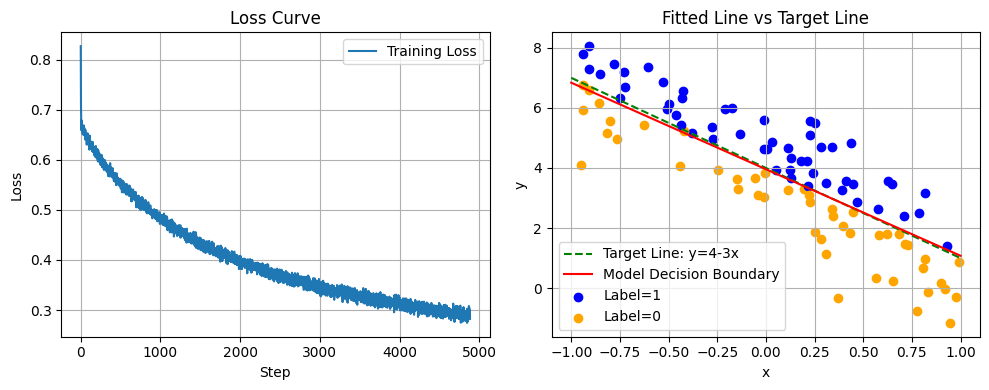

In [11]:
hyper_params = {
    'learning_rate': 5.0e-2,
    'num_epochs': 5,
    'batch_size': 1024,
}

model = Model_2_1().to(device)
trainer = LogisticTrainer(model=model, dataset=dataset, optimizer='manual', criterion='manual', **hyper_params)
trainer.train()

## 题目2
**利用 torch.nn 实现 logistic 回归在人工构造的数据集上进行训练和测试，并对结果进行分析，并从loss以及训练集上的准确率等多个角度对结果进行分析**

使用torch.nn实现模型。

将之前的Model_2_1中的手动实现函数改为torch.nn内置函数即可，再加上继承nn.Module以使用torch.nn内置模型模板特性。

In [12]:
class Model_2_2(nn.Module):
    def __init__(self):
        super(Model_2_2, self).__init__()
        self.linear = nn.Linear(2, 1, dtype=torch.float32)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        return x

训练与测试过程与之前手动实现的一致。

  0%|          | 0/4885 [00:00<?, ?it/s]

{'Epoch': '1/5', 'Total Loss': '563.82', 'Avg Acc': '73.82%'}
{'Epoch': '2/5', 'Total Loss': '434.00', 'Avg Acc': '90.11%'}
{'Epoch': '3/5', 'Total Loss': '367.07', 'Avg Acc': '93.98%'}
{'Epoch': '4/5', 'Total Loss': '325.00', 'Avg Acc': '95.66%'}
{'Epoch': '5/5', 'Total Loss': '295.70', 'Avg Acc': '96.55%'}


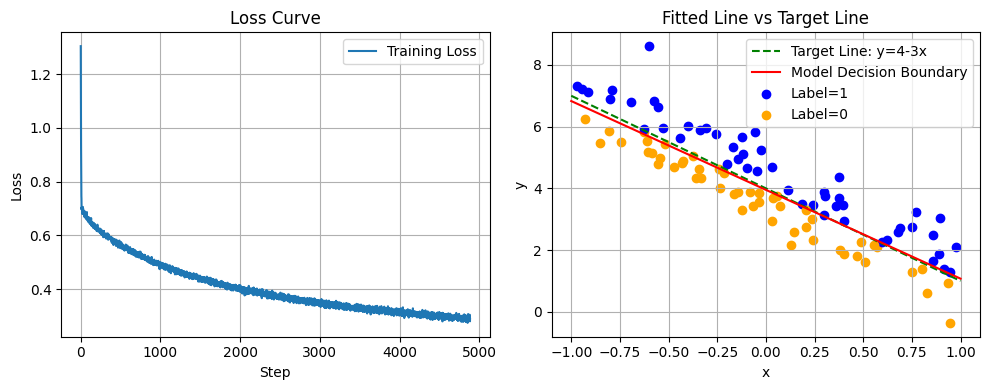

In [13]:
hyper_params = {
    'learning_rate': 5.0e-2,
    'num_epochs': 5,
    'batch_size': 1024,
}

model = Model_2_2().to(device)
trainer = LogisticTrainer(model=model, dataset=dataset, optimizer='torch', criterion='torch', **hyper_params)
trainer.train()

对比发现，手动实现的损失函数和优化器与torch.nn的内置损失函数和优化器相比，表现差不多。

# 三、动手实现softmax回归

## 问题1

**要求动手从0实现softmax回归（只借助Tensor和Numpy相关的库）在Fashion-MNIST数据集上进行训练和测试，并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析（要求从零实现交叉熵损失函数）**

手动实现CrossEntropyLoss。

CrossEntropyLoss由一个log_softmax和一个nll_loss组成。

softmax的数学表达式如下：
$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}} = \frac{e^{x_i - \text{max}(x)}}{\sum_{j=1}^{N} e^{x_j - \text{max}(x)}} 
$$
log_softmax即为$\log(\text{softmax}(x))$，但可以进一步优化：
$$
\text{logsoftmax}(x_i) = \log{\frac{e^{x_i - \text{max}(x)}}{\sum_{j=1}^{N} e^{x_j - \text{max}(x)}}} = x_i - \text{max}(x) - \log{\sum_{j=1}^{N} e^{x_j - \text{max}(x)}}
$$

CrossEntropyLoss的数学表达式如下：
$$
\text{CrossEntropyLoss}(x, \hat{x}) = -\frac{1}{N} \sum_{i=1}^{N} \hat{x}_i \cdot \log(\text{softmax}(x_i)) 
$$

故代码如下：

In [14]:
class My_Softmax:
    def __init__(self, dim: int):
        self.dim = dim
    def __call__(self, x: torch.Tensor):
        max_x = torch.max(x, dim=self.dim, keepdim=True).values
        exp_x = torch.exp(x - max_x)
        return exp_x / torch.sum(exp_x, dim=self.dim, keepdim=True)

def my_logsoftmax(x: torch.Tensor):
    max_x = torch.max(x, dim=1, keepdim=True).values
    exp_x = torch.exp(x - max_x)
    return x - max_x - torch.log(torch.sum(exp_x, dim=1, keepdim=True))

class My_CrossEntropyLoss:
    def __call__(
        self, 
        predictions: torch.Tensor, 
        targets: torch.Tensor, 
        reduction: Literal["mean", "sum"] = "mean"
    ):
        log_probs = my_logsoftmax(predictions)
        
        if len(predictions.shape) == len(targets.shape) + 1:
            nll_loss = -log_probs.gather(1, targets.unsqueeze(-1)).squeeze()
        else:
            nll_loss = -torch.sum(targets * log_probs, dim=1)
            
        if reduction == "mean": 
            return torch.mean(nll_loss)
        else: 
            return torch.sum(nll_loss)

        
# 测试
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1).argmax(1)
print(f"输入：\n{input}")
print(f"标签：\n{target}")

my_crossentropyloss = My_CrossEntropyLoss()
my_loss = my_crossentropyloss(input, target)
print("My_CrossEntropyLoss损失值:", my_loss.item())

nn_crossentropyloss = nn.CrossEntropyLoss()
nn_loss = nn_crossentropyloss(input, target)
print("nn.CrossEntropyLoss损失值:", nn_loss.item())

输入：
tensor([[-0.1808, -0.6778, -0.5920, -0.6382, -1.9187],
        [-0.6441, -0.6061, -0.1425,  0.9727,  2.0038],
        [ 0.6622,  0.5332,  2.7489, -0.3841, -1.9623]], requires_grad=True)
标签：
tensor([2, 0, 1])
My_CrossEntropyLoss损失值: 2.377387762069702
nn.CrossEntropyLoss损失值: 2.377387762069702


接下来实现Softmax回归的Trainer，包括训练流程、测试和画图。

训练softmax回归模型，进行如下步骤：
1. 定义模型、数据集、损失函数、优化器和其他超参数
2. 训练
    1. 从训练dataloader中获取批量数据
    2. 传入模型
    3. 使用损失函数计算与ground_truth的损失
    4. 使用优化器进行反向传播
    5. 循环以上步骤
3. 验证及测试
    1. 从验证或测试dataloader中获取批量数据
    2. 传入模型，验证时需要将模型输出与ground_truth进行比较得计算loss
    3. 将预测值与ground_truth进行比较，得出正确率
    4. 对整个训练集统计正确率，从而分析训练效果

In [15]:
class SoftmaxTrainer():
    def __init__(
        self,
        model,
        train_dataset: Union[Dataset, DataLoader],
        eval_dataset: Union[Dataset, DataLoader],
        test_dataset: Union[Dataset, DataLoader],
        optimizer: Literal['torch', 'manual'],
        criterion: Literal['torch', 'manual'],
        learning_rate: float,
        num_epochs: int,
        batch_size: int,
    ):
        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size

        if isinstance(train_dataset, Dataset):
            self.train_dataloader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.train_dataloader = train_dataset
        if isinstance(eval_dataset, Dataset):
            self.eval_dataloader = DataLoader(
                dataset=eval_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.eval_dataloader = eval_dataset
        if isinstance(test_dataset, Dataset):
            self.test_dataloader = DataLoader(
                dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=cpu_count()
            )
        else:
            self.test_dataloader = test_dataset

        if optimizer == 'torch':
            self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        else:
            self.optimizer = My_Optimizer(model.parameters(), lr=learning_rate)

        if criterion == 'torch':
            self.criterion = nn.CrossEntropyLoss()
            self.softmax = nn.Softmax(dim=1)
        else:
            self.criterion = My_CrossEntropyLoss()
            self.softmax = My_Softmax(dim=1)

    def train(self):
        train_loss_curve = []
        eval_loss_curve = []
        eval_acc_curve = []
        step = 0
        total_train_steps = self.num_epochs * len(self.train_dataloader)
        with tqdm(total=total_train_steps) as pbar:
            for epoch in range(self.num_epochs):
                total_train_loss = 0
                for x, targets in self.train_dataloader:
                    x = x.to(device=device, dtype=torch.float32)
                    targets = targets.to(device=device, dtype=torch.long)

                    self.optimizer.zero_grad()
                    output = self.model(x)
                    loss = self.criterion(output, targets)
                    total_train_loss += loss.item()
                    train_loss_curve.append(loss.item())
            
                    loss.backward()
                    self.optimizer.step()
                    step += 1
                    pbar.update(1)

                avg_eval_loss, avg_eval_acc = self.eval()
                eval_loss_curve.append(avg_eval_loss)
                eval_acc_curve.append(avg_eval_acc)
                log_info = {
                    'Epoch': f'{epoch + 1}/{self.num_epochs}',
                    'Total Train Loss': f'{total_train_loss:.2f}',
                    'Scaled Total Valid Loss': f'{avg_eval_loss * len(self.train_dataloader):.2f}',
                    'Avg Valid Acc': f'{avg_eval_acc:.2%}'
                }
                print(log_info)

        print('Avg Test Acc:', f'{self.test():.2%}')
        self.plot_results(train_loss_curve, eval_loss_curve, eval_acc_curve)

    def eval(self):
        total_eval_loss = 0
        total_eval_acc = 0
        with torch.inference_mode():
            for x, targets in self.eval_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.long)
                output = self.model(x)
                loss = self.criterion(output, targets)
                total_eval_loss += loss.item()
                preds = self.softmax(output).argmax(dim=1)
                total_eval_acc += (preds == targets).float().sum().item()
        
        avg_eval_loss = total_eval_loss / len(self.eval_dataloader)
        num_eval_sample = len(self.eval_dataloader) * self.batch_size
        avg_eval_acc = total_eval_acc / num_eval_sample
        return avg_eval_loss, avg_eval_acc

    def test(self):
        total_test_acc = 0
        with torch.inference_mode():
            for x, targets in self.test_dataloader:
                x = x.to(device=device, dtype=torch.float32)
                targets = targets.to(device=device, dtype=torch.long)
                output = self.model(x)
                preds = self.softmax(output).argmax(dim=1)
                total_test_acc += (preds == targets).float().sum().item()
        num_test_sample = len(self.test_dataloader) * self.batch_size
        avg_test_acc = total_test_acc / num_test_sample
        return avg_test_acc
        
    def plot_results(self, train_loss_curve, eval_loss_curve, eval_acc_curve):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].plot(train_loss_curve, label='Training Loss', color='blue')
        axes[0].plot(
            np.linspace(len(self.train_dataloader), len(train_loss_curve), len(eval_loss_curve), endpoint=True),
            eval_loss_curve, label='Validation Loss', color='orange'
        )
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Loss Curve')
        axes[0].legend()
        axes[0].grid(True)
    
        axes[1].plot(eval_acc_curve, label='Validation Accuracy', color='green', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Validation Accuracy Curve')
        axes[1].legend()
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

手动实现Flatten。

原理很简单，就是把多维的张量拉直成一个向量。

In [16]:
class My_Flatten:
    def __call__(self, x: torch.Tensor):
        return self.forward(x)

    def forward(self, x: torch.Tensor):
        x = x.view(x.shape[0], -1)
        return x


# 测试
my_flatten = My_Flatten()
nn_flatten = nn.Flatten()
x = torch.tensor(
    [[[1., 2.], [3., 4.]],
    [[5., 6.], [7., 8.]]]
)
print(f"Flatten之前的x：\n{x}")
x_my_flatten = my_flatten(x)
print(f"My_Flatten之后的x：\n{x_my_flatten}")
x_nn_flatten = nn_flatten(x)
print(f"nn.Flatten之后的x：\n{x_nn_flatten}")

Flatten之前的x：
tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])
My_Flatten之后的x：
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])
nn.Flatten之后的x：
tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])


手动实现softmax回归模型。

模型很简单，主要由一个Flatten层和一个线性层组成。

Flatten层主要用于将2维的图像展开，直接作为1维的特征量输入网络。

In [17]:
class Model_3_1:
    def __init__(self, num_classes):
        self.flatten = My_Flatten()
        self.linear = My_Linear(28 * 28, num_classes)
        self.params = self.linear.params

    def __call__(self, x: torch.Tensor):
        return self.forward(x)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def to(self, device: str):
        for param in self.params:
            param.data = param.data.to(device=device)
        return self

    def parameters(self):
        return self.params

训练与测试过程与之前手动实现的几乎一致。由于数据集的变化，对应超参数也进行了调整。

数据集也使用了现成的FashionMNIST数据集，且划分了训练集和测试集。

FashionMNIST数据集直接调用API获取。数据集的image为28*28的单通道灰白图片，label为单个数值标签。

Train Dataset Size: 59000
Valid Dataset Size: 1000
Test Dataset Size: 10000
A Train Sample:



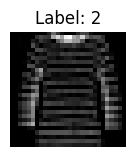

{'Image Type': <class 'torch.Tensor'>, 'Image Shape': torch.Size([1, 28, 28]), 'Label Type': <class 'int'>, 'Label Value': 2}


In [18]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = datasets.FashionMNIST(root="./dataset", train=True, transform=transform, download=True)
eval_size = min(int(len(train_dataset) * 0.1), 1000)
train_dataset, eval_dataset = random_split(train_dataset, [len(train_dataset) - eval_size, eval_size])
test_dataset = datasets.FashionMNIST(root="./dataset", train=False, transform=transform, download=True)
print('Train Dataset Size:', len(train_dataset))
print('Valid Dataset Size:', len(eval_dataset))
print('Test Dataset Size:', len(test_dataset))

image, label = train_dataset[0]
sample = {
    'Image Type': type(image),
    'Image Shape': image.shape,
    'Label Type': type(label),
    'Label Value': label
}
print('A Train Sample:\n')
image = image * 0.5 + 0.5 # 将图像从 [-1, 1] 还原到 [0, 1] 以便更好地可视化
plt.figure(figsize=(1.5, 1.5))
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()
print(sample)

num_classes = 10

开始训练。

  0%|          | 0/1160 [00:00<?, ?it/s]

{'Epoch': '1/20', 'Total Train Loss': '395.61', 'Scaled Total Valid Loss': '209.01', 'Avg Valid Acc': '59.18%'}
{'Epoch': '2/20', 'Total Train Loss': '199.74', 'Scaled Total Valid Loss': '160.59', 'Avg Valid Acc': '65.82%'}
{'Epoch': '3/20', 'Total Train Loss': '163.67', 'Scaled Total Valid Loss': '138.08', 'Avg Valid Acc': '67.68%'}
{'Epoch': '4/20', 'Total Train Loss': '144.33', 'Scaled Total Valid Loss': '124.88', 'Avg Valid Acc': '70.61%'}
{'Epoch': '5/20', 'Total Train Loss': '131.63', 'Scaled Total Valid Loss': '115.56', 'Avg Valid Acc': '71.97%'}
{'Epoch': '6/20', 'Total Train Loss': '122.55', 'Scaled Total Valid Loss': '111.07', 'Avg Valid Acc': '72.75%'}
{'Epoch': '7/20', 'Total Train Loss': '115.34', 'Scaled Total Valid Loss': '105.69', 'Avg Valid Acc': '72.75%'}
{'Epoch': '8/20', 'Total Train Loss': '109.65', 'Scaled Total Valid Loss': '101.89', 'Avg Valid Acc': '74.02%'}
{'Epoch': '9/20', 'Total Train Loss': '105.07', 'Scaled Total Valid Loss': '99.39', 'Avg Valid Acc': '74

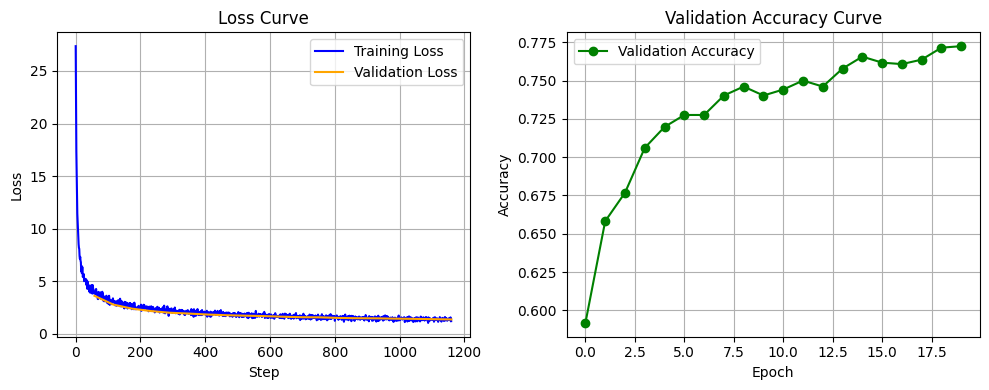

In [19]:
hyper_params = {
    'learning_rate': 2.0e-1,
    'num_epochs': 20,
    'batch_size': 1024,
}

model = Model_3_1(num_classes).to(device)

trainer = SoftmaxTrainer(
    model=model, 
    train_dataset=train_dataset, eval_dataset=eval_dataset, test_dataset=test_dataset, 
    optimizer='manual', criterion='manual', **hyper_params
)
trainer.train()

模型正常收敛。

## 问题2

**利用torch.nn实现softmax回归在Fashion-MNIST数据集上进行训练和测试，并从loss，训练集以及测试集上的准确率等多个角度对结果进行分析**

使用torch.nn实现模型。

将之前的Model_3_1中的手动实现函数改为torch.nn内置函数即可，再加上继承nn.Module以使用torch.nn内置模型模板特性。

In [20]:
class Model_3_2(nn.Module):
    def __init__(self, num_classes):
        super(Model_3_2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28 * 28, num_classes)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = self.linear(x)
        return x

训练与测试过程与之前手动实现的几乎一致。

  0%|          | 0/1160 [00:00<?, ?it/s]

{'Epoch': '1/20', 'Total Train Loss': '64.68', 'Scaled Total Valid Loss': '44.60', 'Avg Valid Acc': '73.63%'}
{'Epoch': '2/20', 'Total Train Loss': '42.82', 'Scaled Total Valid Loss': '37.81', 'Avg Valid Acc': '75.00%'}
{'Epoch': '3/20', 'Total Train Loss': '38.36', 'Scaled Total Valid Loss': '34.98', 'Avg Valid Acc': '76.66%'}
{'Epoch': '4/20', 'Total Train Loss': '36.04', 'Scaled Total Valid Loss': '33.33', 'Avg Valid Acc': '77.15%'}
{'Epoch': '5/20', 'Total Train Loss': '34.46', 'Scaled Total Valid Loss': '31.78', 'Avg Valid Acc': '77.83%'}
{'Epoch': '6/20', 'Total Train Loss': '33.34', 'Scaled Total Valid Loss': '30.91', 'Avg Valid Acc': '78.22%'}
{'Epoch': '7/20', 'Total Train Loss': '32.49', 'Scaled Total Valid Loss': '30.01', 'Avg Valid Acc': '78.81%'}
{'Epoch': '8/20', 'Total Train Loss': '31.77', 'Scaled Total Valid Loss': '29.30', 'Avg Valid Acc': '79.49%'}
{'Epoch': '9/20', 'Total Train Loss': '31.17', 'Scaled Total Valid Loss': '28.90', 'Avg Valid Acc': '79.30%'}
{'Epoch': 

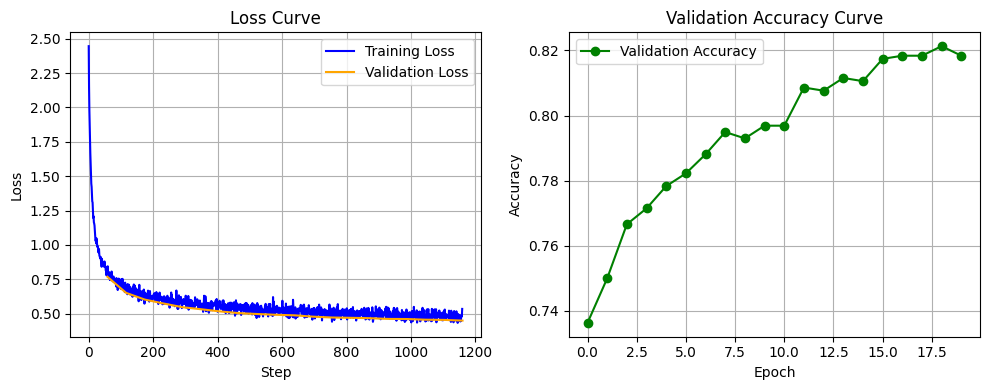

In [21]:
hyper_params = {
    'learning_rate': 2.0e-2,
    'num_epochs': 20,
    'batch_size': 1024,
}

model = Model_3_2(num_classes).to(device)

trainer = SoftmaxTrainer(
    model=model, 
    train_dataset=train_dataset, eval_dataset=eval_dataset, test_dataset=test_dataset, 
    optimizer='manual', criterion='manual', **hyper_params
)
trainer.train()